### Ignitions analysis

In [1]:
using Stripeline
using Plots
using Healpix
using Statistics
using LaTeXStrings

In [2]:
#Since Julia's efficency is way improved by the use of functions, here we define all the functions we'll be using in the code

function period_tod(zeros, counts, durations, n, sampling)    #This fill a single period of the tod
    m=0
    while m<durations[3]    #m is a minute of the period, i is the index governing the tod
        if m<durations[1]    #It means we are in the unstable part of the period
            v=0.5
            c=1
        end
        if m>=durations[1] && m<durations[2]    #It means we are in the stable part of the period
            v=1
            c=1
        end
        if m>=durations[2] && m<durations[3]    #It means we are in the off part of the period
            v=0
            c=2
        end
        b=((n*durations[3])+m)*sampling
        for a=1:sampling    #A complete cicle corresponds to an entire minute of the period which corresponds to sampling components of the tod
            if (b+a)<=length(zeros)
                zeros[b+a]=v
                counts[c]+=1
                a+=1
            end
            if (b+a)>length(zeros)
                a=sampling+10
                m=durations[3]+10
            end
        end
        m+=1
    end
end

function fill_tod(zeros, counts, durations, periods, sampling, y)    #Through period_tod this fill the entire tod
    #For each moment in wich the calibrator is on the tod's value should be 1 instead of 0, at the beginning of the experiment the calibrator is on. During the first minute of each ignition the tod's value will be 0.5 so that we can distinguish it from the following nine
    for n=0:periods    #We fill each period separately using another function
        period_tod(zeros, counts, durations, n, sampling)
        n+=1
    end
end

function project_to_map(time_samples, map, tod)
    telescope_motors(time_s)=(0.0, deg2rad(20.0), timetorotang(time_s, 1))
    dirs, _=genpointings(telescope_motors, Float64[0, 0, 1], time_samples)   #We only need the direction so we omit the second return value
    for k in 1:length(time_samples)
        colat, long=dirs[k, :]    #Extract the colatitude and the longitude from "dirs"
        pixel_index=ang2pix(map, colat, long)
        if tod[k]>0    #This analisys aim to study the calibration process so we only use the stable calibrator's ignitions
            map[pixel_index]+=1    #Every time a pixel is covered by the calibrator's signal, it's colour value is increased by a constant value This way we can both see wich parts of the sky are covered and how many times the calibrator obscures them.  
        end
        if tod[k]==0 && map[pixel_index]==0
            map[pixel_index]=0.5   #This way we can distinguish the pixels in the strip visible to the telescope from the ones out of it
        end
        if map[pixel_index]>0.5 && (map[pixel_index]%1)!=0
            map[pixel_index]-=0.5   #We want the pixel_index to represents the number of calibrator's passages over a pixel, so we don't want our method to identify the strip to ruin this physical meaning
        end
    end
end

function pixels_counter(map)
    strip_pixels=0    #This indicates the total number of pixels in the strip, we need this to evaluate the total dev_st
    on_pixels=0    #Here we count only the pixel seen at least once when the calibrator is on for the on dev_st
    for u in 1:length(map.pixels)
        if map[u]!=0    #Because of the way we defined map[pixel_index] before, if this equals 0 the telescope never sees this pixel, if the value is 0.5 the telescope sees the pixel but the calibrator's signal never coverd it, if it's 1 ore more the calibrator covered it at least once. This way only the pixels for which this value is not null are in the strip
            strip_pixels+=1
        end
        if map[u]>=1    #We don't count the pixells always seen when the calibrator is off
            on_pixels+=1
        end
        u+=1
    end
    return strip_pixels, on_pixels
end

function coveradge_counter(map, pixels, hit_count, tot_count_diff, on_count_diff, ideals)    #This fills the arrays keeping track of the hit count of the considered pixels
    j=1    #We need an index to controll the filling array
    for r in 1:length(pixels)
        if map[r]==0.5    #This pixel has not been covered by the calibrator's signal so we put it in the strip pixels array but whit its real count null
            hit_count[j]=0
            tot_count_diff[j]=-ideals[1]
            j+=1    #We increment this index only when the hit count is >0
        end
        if map[r]>=1
            hit_count[j]=map[r]
            tot_count_diff[j]=hit_count[j]-ideals[1]
            on_count_diff[j]=hit_count[j]-ideals[2]
            j+=1
        end
        r+=1
    end
end

coveradge_counter (generic function with 1 method)

In [3]:
obs_time=60*24    #Total observation time expressed in minutes
stab_duration=1    #Stabilization time expressed in minutes. This is fixed because is a constructive characteristic, indipendent form the signal's duration
cal_interval=125    #Time interval between two ignitions, we fix this usingg the optimization study made before. It's expressed in minutes
frequency=50    #Sampling frequency in Hz i.e. number of samples per seconds
sampling=frequency*60    #Samples per minute i.e. sampling frequency * 60 seconds
time_samples=0.0:1/frequency:obs_time*60    #Array of time values in which we take measurements, i.e. time range in seconds sampled using the choosen frequency
cal_durations=2:1:60    #We define an array of values we'll use as time duration of a single (stable) ignition to compare them, here we express them in minutes
#We define the associated arrays of standard deviations in the two different conditions and the array of observational time
dev_sts_tot=zeros(Float64, length(cal_durations), 1)    #We'll define the associated mean value using the number of pixels in the entire Strip
dev_sts_on=zeros(Float64, length(cal_durations), 1)    #We'll define the associated mean value using only the pixels seen during the on time
frac_time=zeros(Float64, length(cal_durations), 1)
println(length(cal_durations), "   |   ", length(time_samples))

59   |   4320001


In [4]:
#Here we run the simulation
for ind in 1:length(cal_durations)
    #We define the tod wich will be used to simulate the calibrator
    counts=[0, 0]    #Onche filled the array is defined as follows. First component: number of samples during which the calibrator is on but unstable. Second component: number of samples during which the calibrator is on and stable. Third component: number of samples during which the calibrator is off.
    durations=[stab_duration, cal_durations[ind]+stab_duration, cal_interval+cal_durations[ind]+stab_duration]    #This array represents the division of a period of the calibrator's action expressed in minutes
    tod=zeros(Float64, length(time_samples), 1)    #The entire tod is initialized to zero
    n_per=cld(obs_time, durations[3])    #Number of periods in which the total time can be divided rounded to the maximum integer possible  
    fill_tod(tod, counts, durations, n_per, sampling, 0)    #We fill the tod. When the value is 0.5 the calibrator is on but unstable, when it equals 1 the calibrator is on and stable, if the calibrator is off the value remains 0.   
    #Now we work on the standard deviation
    #We now build the map (without plotting it)
    map=Healpix.HealpixMap{Float64, RingOrder}(256)   #We create a map wich represents the whole sky
    project_to_map(time_samples, map, tod)    #Here we run the simulation
    #We need to evaluate in a quantitative way the uniformity of the calibrator signal's coverage so we can start by studying map.pixels i.e. the array containing the count of the calibrator's coverages af each pixel
    #we need to select the part of the circled map that corresponds to the strip covered by Stripeline, this is the area in which we want to uniform the hit count for the total dev_st, then 
    pixels=[0, 0]    #The first component kepp track of the number of pixels seen at least one by the calibrator on or off, the second only the pixels seen by the calibrator on (stable or not)
    pixels[1], pixels[2]=pixels_counter(map)
    ideals=[0., 0.]    #This keeps count of the ideal values
    ideals[1]=counts[1]/pixels[1]    #If all the pixels were seen the same number of times this would be their hit count (i.e. their value in the map). This is the mean value for dev_st_tot
    ideals[2]=counts[1]/pixels[2]    #Mean value for on_dev_st
    #We define and fill three arrays storing only the data we need to make the real analysis
    hit_count=zeros(Float64, pixels[1], 1)    #The hit count of every pixel in the strip
    tot_count_diff=zeros(Float64, pixels[1], 1)    #The difference between the real count of every pixel in the strip and the ideal value
    on_count_diff=zeros(Float64, pixels[1], 1)    #The difference between the real count of every pixel in the strip and the ideal value
    coveradge_counter(map, map.pixels, hit_count, tot_count_diff, on_count_diff, ideals)   #Here we fill the arrays previuosly created
    #We adjourn the final arrays
    dev_sts_tot[ind]=stdm(tot_count_diff, ideals[1], corrected=true)    #Standard deviation considering the whole strip
    dev_sts_on[ind]=stdm(on_count_diff, ideals[2], corrected=true)    #Standard deviation considering only the on_pixels
    frac_time[ind]=counts[2]/length(time_samples)    #Here we want to study the time during witch we see the sky
    println("Component ", ind, " of ", length(cal_durations), " has been processed.")
    ind+=1
end

Component 1 of 59 has been processed.
Component 2 of 59 has been processed.
Component 3 of 59 has been processed.
Component 4 of 59 has been processed.
Component 5 of 59 has been processed.
Component 6 of 59 has been processed.
Component 7 of 59 has been processed.
Component 8 of 59 has been processed.
Component 9 of 59 has been processed.
Component 10 of 59 has been processed.
Component 11 of 59 has been processed.
Component 12 of 59 has been processed.
Component 13 of 59 has been processed.
Component 14 of 59 has been processed.
Component 15 of 59 has been processed.
Component 16 of 59 has been processed.
Component 17 of 59 has been processed.
Component 18 of 59 has been processed.
Component 19 of 59 has been processed.
Component 20 of 59 has been processed.
Component 21 of 59 has been processed.
Component 22 of 59 has been processed.
Component 23 of 59 has been processed.
Component 24 of 59 has been processed.
Component 25 of 59 has been processed.
Component 26 of 59 has been proces

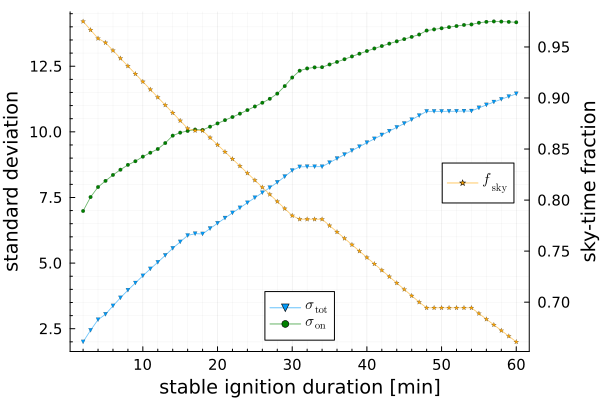

In [30]:
#We plot the three dataset in a single cartesian plane and then separately
plot(cal_durations, dev_sts_tot, xlabel="stable ignition duration [min]", ylabel="standard deviation", minorgrid=true, markershape=:dtriangle, markersize=2, markerstrokewidth=0.2, linewidth=0.8, linealpha=0.6, label=L"\sigma_\mathrm{tot}", legend=:bottom)
plot!(cal_durations, dev_sts_on, markershape=:circle, markersize=2, markercolor=:green, markerstrokewidth=0.2, linewidth=0.8, linealpha=0.6, linecolor=:green, label=L"\sigma_\mathrm{on}")
plot!(twinx(), cal_durations, frac_time, ylabel="sky-time fraction", markershape=:star5, markersize=2.5, markercolor=:orange, markerstrokewidth=0.2, linewidth=0.8, linecolor=:orange, linealpha=0.6, label=L"f_\mathrm{sky}", legend=:right)

In [6]:
#We plot the three dataset in a single cartesian plane and then separately

plot(cal_durations, dev_sts_tot, xlabel=L"t_\mathrm{cal}\;[\mathrm{min}]", ylabel=L"\sigma", minorgrid=true, markershape=:diamond, markersize=2, linewidth=0.8, linealpha=0.6, label=L"\sigma_\mathrm{tot}", legend=:bottom)
plot!(cal_durations, dev_sts_on, markershape=:circle, markersize=2, markercolor=:green, linewidth=0.8, linecolor=:green, linealpha=0.6, label=L"\sigma_\mathrm{on}")
plot!(twinx(), cal_durations, frac_time, ylabel=L"f_\mathrm{sky}", markershape=:star5, markersize=2, markercolor=:orange, linewidth=0.8, linealpha=0.6, linecolor=:orange, label=L"f_\mathrm{sky}", legend=:right)
savefig("plot_dur_compl.pdf")

plot(cal_durations, dev_sts_tot, xlabel=L"t_\mathrm{cal}\;[\mathrm{min}]", ylabel=L"\sigma_\mathrm{tot}", minorgrid=true, markershape=:circle, markersize=2, linewidth=0.8, linealpha=0.6, legend=:false)
savefig("plot_dur_sdt.pdf")

plot(cal_durations, dev_sts_on, xlabel=L"t_\mathrm{cal}\;[\mathrm{min}]", ylabel=L"\sigma_\mathrm{on}", minorgrid=true, markershape=:circle, markersize=2, markercolor=:green, linewidth=0.8, linecolor=:green, linealpha=0.6, legend=:false)
savefig("plot_dur_sdo.pdf")

plot(cal_durations, frac_time, xlabel=L"t_\mathrm{cal}\;[\mathrm{min}]", ylabel=L"f_\mathrm{sky}", minorgrid=true, markershape=:circle, markersize=2, markercolor=:orange, linewidth=0.8, linecolor=:orange, linealpha=0.6, legend=:false)
savefig("plot_dur_tf.pdf")

"C:\\Users\\user\\Tesi triennale\\plot_dur_tf.pdf"